# San Francisco Crime prediction 
# Based on 2 layer neural net and count featurizer

In [1]:
import os
import pandas as pd
import re

import numpy as np
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy

import mkl

%matplotlib inline  

Using Theano backend.


Import data

In [2]:
data_path = "data"
submissions_path = "submissions"

In [3]:
trainDF=pd.read_csv(os.path.join(data_path, "train.csv"))


Clean up wrong X and Y values (very few of them)

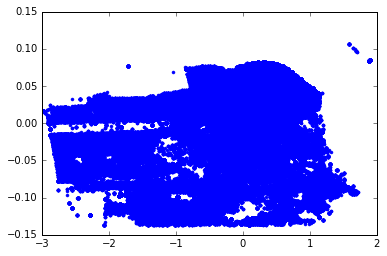

In [4]:
xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(trainDF[["X","Y"]])
trainDF[["X","Y"]]=xy_scaler.transform(trainDF[["X","Y"]])
trainDF=trainDF[abs(trainDF["Y"])<100]
trainDF.index=range(len(trainDF))
plt.plot(trainDF["X"],trainDF["Y"],'.')
plt.show()

Make plots for each crime label

In [5]:
trainDF.shape


(349973, 9)

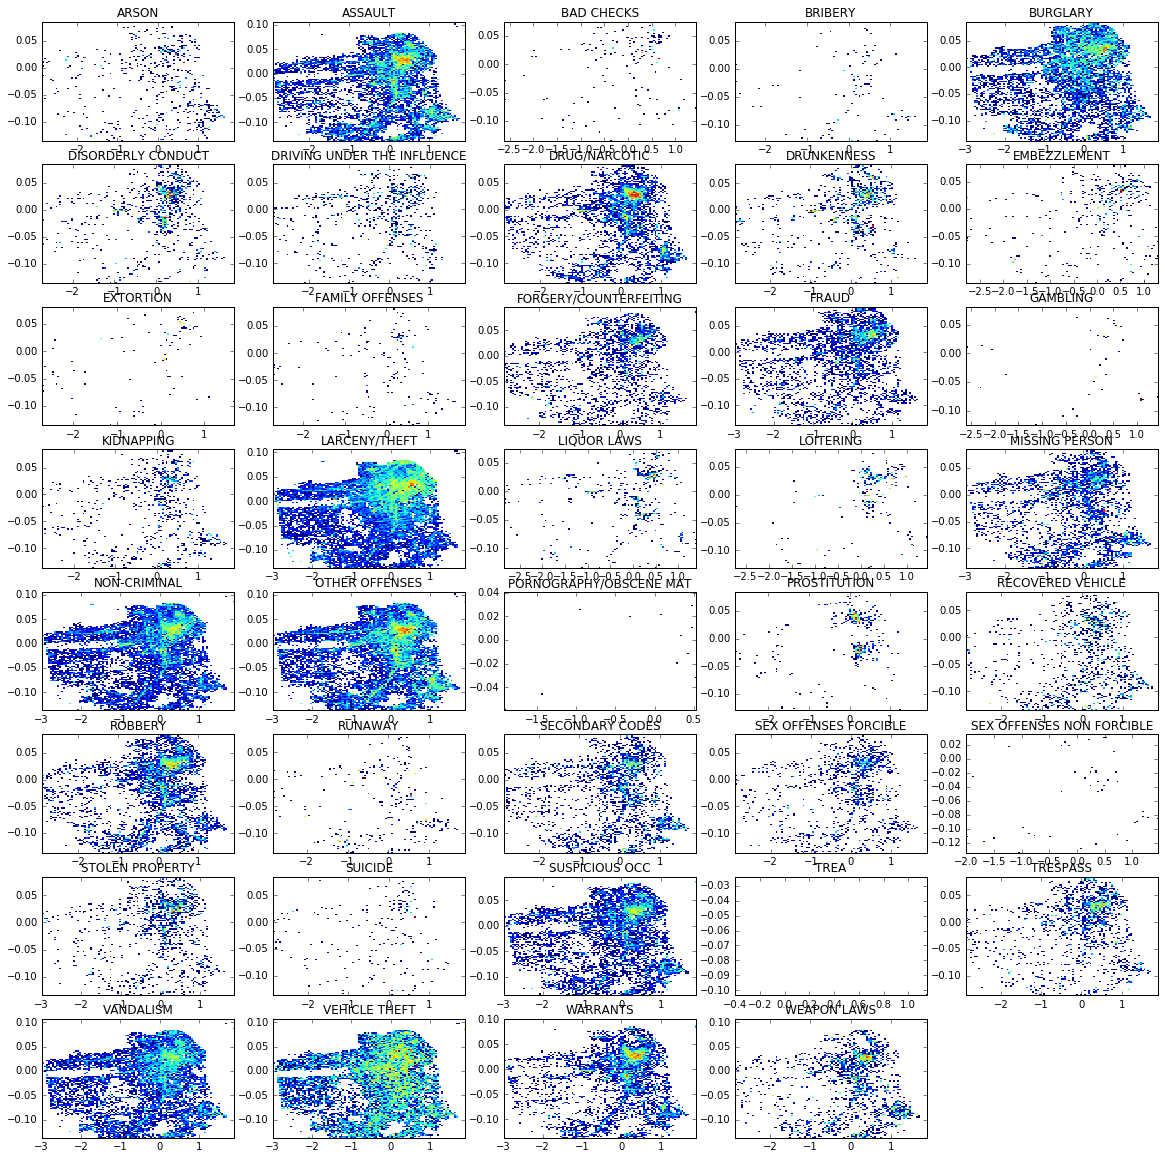

In [6]:
NX=100
NY=100
groups = trainDF.groupby('Category')
ii=1
plt.figure(figsize=(20, 20))
for name, group in groups:
    plt.subplot(8,5,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
#     plt.figure(ii)
#     plt.plot(group.X,group.Y,'.')
    ii+=1
del groups

# Now proceed as before

In [7]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

def get_street(x):
    if  "/" in x: 
        return re.findall(r'([A-Z0-9 ]+)\s/\s?([A-Z0-9 ]*)', x)[0]
    else: 
        street = re.findall(r'\d+.*?\s+Block of ([A-Z0-9 ]+)', x)[0]
        return street,street

In [8]:
#Jackson Code

groupKey = ["Awake","PdDistrict","Address"]

def engineer_data(df):
    
    df2 = df.copy()
    df2["Time"], df2["Day"], df2["Month"], df2["Year"]=zip(*df2["Dates"].apply(parse_time))    
    df2["IsIntersection"]=df2["Address"].apply(lambda x: 1 if "/" in x else 0)
    df2["Awake"]=df2["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    df2["Summer"], df2["Fall"], df2["Winter"], df2["Spring"]=zip(*df2["Month"].apply(get_season))
    df2["Street1"],df2["Street2"] = zip(*df2["Address"].apply(get_street))
    return df2

In [9]:
trainDF = engineer_data(trainDF)

def createLogOdds(togroup,X,y=None,p=False):
        categories=sorted(y.unique())
        X2 = X.assign(Category=y.astype('object'))
        C_counts=X2.groupby(["Category"]).size()
        def recurseLogOdds(key):
            if len(key) < 1: 
                return np.log(C_counts/len(X2))-np.log(1.0-C_counts/float(len(X2)))
            parent_logodds= recurseLogOdds(key[:-1])
            G_C_counts=X2.groupby(key +["Category"]).size()
            G_counts=X2.groupby( key).size()
            groups=G_counts.keys()        
            logodds={}
            MIN_CAT_COUNTS=1
            for addr in groups:
                if len(key) == 2:
                    default =parent_logodds[addr[0]]
                elif len(key) > 2:
                    default =parent_logodds[addr[:-1]]
                else: default = parent_logodds
                logodds[addr]=deepcopy(default)
                for cat in G_C_counts[addr].keys():
                    if (G_C_counts[addr][cat]>MIN_CAT_COUNTS) and G_C_counts[addr][cat]<G_counts[addr]:
                        PA=G_C_counts[addr][cat]/float(G_counts[addr])
                        logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)

            return logodds
        logodds = recurseLogOdds(togroup)
        return pd.DataFrame(logodds.values(), index=pd.MultiIndex.from_tuples(logodds.keys()))



C_counts=trainDF.groupby(["Category"]).size()

default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))
    
def getLogOdds(key,logodds):
    while (len(key) > 0):
        if key in logodds.index:
            return np.mean(np.atleast_2d(logodds.loc[key]),axis=0)
        else: key = key[:-1]
    return default_logodds
    



In [10]:
logodds = createLogOdds(groupKey,trainDF,trainDF.loc[:,"Category"],True)

/opt/anaconda2/lib/python2.7/site-packages/pandas/indexes/multi.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_value(s, k)


In [11]:
def parse_data(df,logodds,logoddsPA,togroup=["Address"]):
    
    feature_list=df.columns.tolist()
    
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")
        
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    
    print "Creating address features"
    address_features=cleanData[togroup].apply(lambda x: pd.Series(getLogOdds(tuple(x),logodds)),axis=1)
    print(address_features.shape)
    address_features.columns=["logodds"+str(x) for x in range(len(address_features.columns))]
    
    print "Parsing dates"
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
#     dummy_ranks_DAY = pd.get_dummies(cleanData['DayOfWeek'], prefix='DAY')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#     cleanData["DayOfWeek"]=cleanData["DayOfWeek"].apply(lambda x: days.index(x)/float(len(days)))

    print "Creating one-hot variables"
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    
    cleanData["IsIntersection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPA"]=cleanData["Address"].apply(lambda x: logoddsPA[x])
    
    print "droping processed columns"
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)
    cleanData=cleanData.drop("Dates",axis=1)
    cleanData=cleanData.drop("Street1",axis=1)
    cleanData=cleanData.drop("Street2",axis=1)

    feature_list=cleanData.columns.tolist()
    
    print "joining one-hot features"
    features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:]).join(address_features.ix[:,:])
    
    print "creating new features"
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(take_last=True)).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
#         label_names=labels.unique()
#         labels=labels.cat.rename_categories(range(len(label_names)))
    else:
        labels=None
    return features,labels

This part is slower than it needs to be.

In [ ]:
addresses=sorted(trainDF["Address"].unique())
categories=sorted(trainDF["Category"].unique())

C_counts=trainDF.groupby(["Category"]).size()
A_C_counts=trainDF.groupby(["Address","Category"]).size()

A_counts=trainDF.groupby(["Address"]).size()

#logodds={}
logoddsPA={}

MIN_CAT_COUNTS=2

default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))

for addr in addresses:
    PA=A_counts[addr]/float(len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

In [ ]:
features, labels=parse_data(trainDF,logodds.sortlevel(),logoddsPA,groupKey)

Creating address features


In [ ]:
print features.columns.tolist()
print len(features.columns)

In [ ]:
# num_feature_list=["Time","Day","Month","Year","DayOfWeek"]
collist=features.columns.tolist()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
features[collist]=scaler.transform(features)

In [ ]:
new_PCA=PCA(n_components=60)
new_PCA.fit(features)
plt.plot(new_PCA.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")
print new_PCA.explained_variance_ratio_

In [ ]:
plt.plot(new_PCA.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")

PCA is interesting, here to play with it more

In [ ]:
# features=new_PCA.transform(features)
# features=pd.DataFrame(features)

In [ ]:
sss = StratifiedShuffleSplit(labels, train_size=0.5)
for train_index, test_index in sss:
    features_train,features_test=features.iloc[train_index],features.iloc[test_index]
    labels_train,labels_test=labels[train_index],labels[test_index]
features_test.index=range(len(features_test))
features_train.index=range(len(features_train))
labels_train.index=range(len(labels_train))
labels_test.index=range(len(labels_test))
features.index=range(len(features))
labels.index=range(len(labels))

In [ ]:
def build_and_fit_model(X_train,y_train,X_test=None,y_test=None,hn=128,dp=0.5,layers=1,epochs=1,batches=64,verbose=0):
    input_dim=X_train.shape[1]
    output_dim=len(labels_train.unique())
    Y_train=y_train.cat.rename_categories(range(len(y_train.unique())))

    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=hn, init='glorot_uniform'))
    model.add(PReLU(input_shape=(hn,)))
    model.add(Dropout(dp))

    for i in range(layers):
        model.add(Dense(input_dim=hn, output_dim=hn,init='glorot_uniform'))
        model.add(PReLU(input_shape=(hn,)))
        model.add(BatchNormalization())
        model.add(Dropout(dp))

    model.add(Dense(input_dim=hn, output_dim=output_dim,init='glorot_uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    if X_test is not None:
        Y_test=y_test.cat.rename_categories(range(len(y_test.unique())))
        fitting=model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose,validation_data=(X_test,Y_test))
        test_score = log_loss(y_test, model.predict_proba(X_test,verbose=0))
    else:
        model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose)
        fitting=0
        test_score = 0
    return test_score, fitting, model

In [ ]:
#features.columns.tolist()

#features.head()

In [ ]:
N_EPOCHS=20
N_HN=256 #39
N_LAYERS=1
DP=0.5

In [ ]:
score, fitting, model = build_and_fit_model(features_train.as_matrix(),labels_train,X_test=features_test.as_matrix(),y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

In [ ]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

In [ ]:
plt.plot(fitting.history['val_loss'],label="validation")
plt.plot(fitting.history['loss'],label="train")
# plt.xscale('log')
plt.legend()

Now train the final model

In [ ]:
features.shape

In [ ]:
score, fitting, model = build_and_fit_model(features.as_matrix(),labels,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

In [ ]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

In [ ]:
testDF=pd.read_csv(os.path.join(data_path,"test.csv"))
testDF[["X","Y"]]=xy_scaler.transform(testDF[["X","Y"]])
#set outliers to 0
testDF["X"]=testDF["X"].apply(lambda x: 0 if abs(x)>5 else x)
testDF["Y"]=testDF["Y"].apply(lambda y: 0 if abs(y)>5 else y)


In [ ]:
testDF = engineer_data(testDF)


In [ ]:
new_addresses=sorted(testDF["Address"].unique())
new_A_counts=testDF.groupby("Address").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA=new_A_counts[addr]/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    #logodds[addr]=deepcopy(default_logodds)
    #logodds[addr].index=range(len(categories))
for addr in in_both:
    PA=(A_counts[addr]+new_A_counts[addr])/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

In [ ]:
features_sub, _=parse_data(testDF,logodds.sortlevel(),logoddsPA,groupKey)
# scaler.fit(features_test)

In [ ]:
collist=features_sub.columns.tolist()
print len(collist)

In [ ]:
features_sub[collist]=scaler.transform(features_sub[collist])

In [ ]:
predDF=pd.DataFrame(model.predict_proba(features_sub.as_matrix(),verbose=0),columns=sorted(labels.unique()))

In [ ]:
predDF.head()

In [ ]:
predDF.to_csv(os.path.join(submissions_path, "crimeSF_NN_logodds211.csv"),index_label="Id",na_rep="0")

In [ ]:
features_sub.head()